# KMeans: Find K (Core)
- Student: Michael McCann
- Date: 23 MAR 2022

In [102]:
## Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [104]:
## Improt Data
df = pd.read_csv('https://raw.githubusercontent.com/Nikhil-Adithyan/Customer-Segmentation-with-K-Means/master/cust_seg.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
display(df.head())
print('\n\n')
df.info()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,5,47,1,31,253,9.308,8.908,0.0,7.2





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [105]:
# Check for dupes and NAs
print (f'Duplicates: {df.duplicated().sum()}')
print (f'NAs: {df.isna().sum().sum()}')

Duplicates: 0
NAs: 150


In [106]:
# 150 NA's in the Default column...
# Create a DF to run XGB to predict our NAs in Default
cat_df = df.copy()
cat_df.dropna(inplace = True) # drop NAs to train/test on the remaining 700
cat_df.isna().sum().sum()

0

In [107]:
# Check distribution of defaulted
cat_df['Defaulted'].value_counts() 

0.0    517
1.0    183
Name: Defaulted, dtype: int64

In [108]:
# Train test split for our XGB 
X = cat_df.drop(columns = ['Customer Id', 'Defaulted'])
y = cat_df['Defaulted']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [109]:
# Instantiate XGB and fit to training data
from xgboost import XGBClassifier
xgb = XGBClassifier()

xgb.fit(X_train, y_train)

# Test the model... .789 is not perfect but it is better than having 150 NAs
print(f'XGB train score: {xgb.score(X_train, y_train):.3f}')
print(f'XGB test score: {xgb.score(X_test, y_test):.3f}')

XGB train score: 0.901
XGB test score: 0.789


In [110]:
# Create predicted values column for our original DF
df_pred = df.drop(columns = ['Customer Id', 'Defaulted'])
df['predict'] = xgb.predict(df_pred)

In [111]:
# replace the NAs in the Defaulted column with our predicted values

### Why doesn't this work??????
# df.loc[df['Defaulted'].isna(),['Defaulted']] = df.loc[df['Defaulted'].isna(),['predict']]

## One Solution
# df['default_fix'] = np.where(df['Defaulted']>=0, df['Defaulted'], df['predict'])
# df.drop(columns = ['Defaulted', 'predict'], inplace = True)
# df.rename(columns = {'default_fix': 'Defaulted'}, inplace = True)


## Using a Loop.
for i in range(0, df.shape[0]):
    if (df.loc[i, 'Defaulted'] != 0.0) & (df.loc[i, 'Defaulted'] != 1.0):
        df.loc[i, 'Defaulted'] = df.loc[i, 'predict'] 

df.head(10)

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,predict
0,1,41,2,6,19,0.124,1.073,0.0,6.3,0.0
1,2,47,1,26,100,4.582,8.218,0.0,12.8,0.0
2,3,33,2,10,57,6.111,5.802,1.0,20.9,1.0
3,4,29,2,4,19,0.681,0.516,0.0,6.3,0.0
4,5,47,1,31,253,9.308,8.908,0.0,7.2,0.0
5,6,40,1,23,81,0.998,7.831,0.0,10.9,0.0
6,7,38,2,4,56,0.442,0.454,0.0,1.6,0.0
7,8,42,3,0,64,0.279,3.945,0.0,6.6,0.0
8,9,26,1,5,18,0.575,2.215,0.0,15.5,0.0
9,10,47,3,23,115,0.653,3.947,0.0,4.0,0.0


In [112]:
# Check to se that it worked...

df[df['Defaulted'] == df['predict']]

print(f"NA's remaining after prediction: {df.isna().sum().sum()} \n")

print("Value Counts for Defaulted")
df['Defaulted'].value_counts()

NA's remaining after prediction: 0 

Value Counts for Defaulted


0.0    643
1.0    207
Name: Defaulted, dtype: int64

In [113]:
#create df with features to test for KMeans.
df = df.drop(columns = ['Customer Id', 'predict']) 

In [114]:
# Instantiate scaler and scale data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

In [115]:
inertias = []

for k in range(2,11):
    km = KMeans(n_clusters=k)
    km.fit(scaled_df)
    inertias.append(km.inertia_)

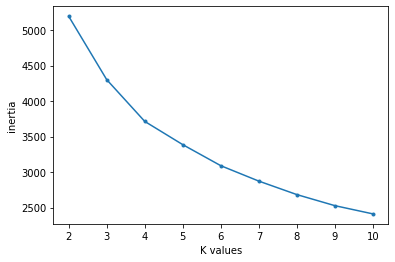

In [116]:
plt.plot(range(2,11), inertias, marker = '.')
plt.xlabel('K values')
plt.ylabel('inertia');

# No clear Elbow. Probably between 2 and 4? Clear flattening at 5+. 

In [117]:
sil = []

for k in range(2,11):
    km = KMeans(n_clusters=k)
    km.fit(scaled_df)
    sil.append(silhouette_score(scaled_df, km.labels_))

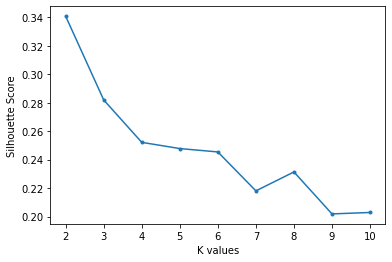

In [118]:
plt.plot(range(2,11), sil, marker = '.')
plt.xlabel('K values')
plt.ylabel('Silhouette Score');

# 2 clusters provided the highest silhouette score of ~0.34. Might make sense as default is a binary yes/no....

In [119]:
# Best KMeans:

km_best = KMeans(n_clusters= 2)
km_best.fit(scaled_df)

KMeans(n_clusters=2)